In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [4]:
text = open('Text.txt', 'r').read().lower()

In [4]:
text[:10]

'au lecteur'

In [5]:
chars = sorted(list(set(''.join(text))))
string_to_index = {s:i for i,s in enumerate(chars)}

In [5]:
N = torch.zeros((35, 35), dtype=torch.int32)

In [6]:
for ch1, ch2 in zip(text, text[1:]):
    N[string_to_index[ch1], string_to_index[ch2]] += 1

In [6]:
index_to_string = {i:s for s,i in string_to_index.items()}

(-0.5, 34.5, 34.5, -0.5)

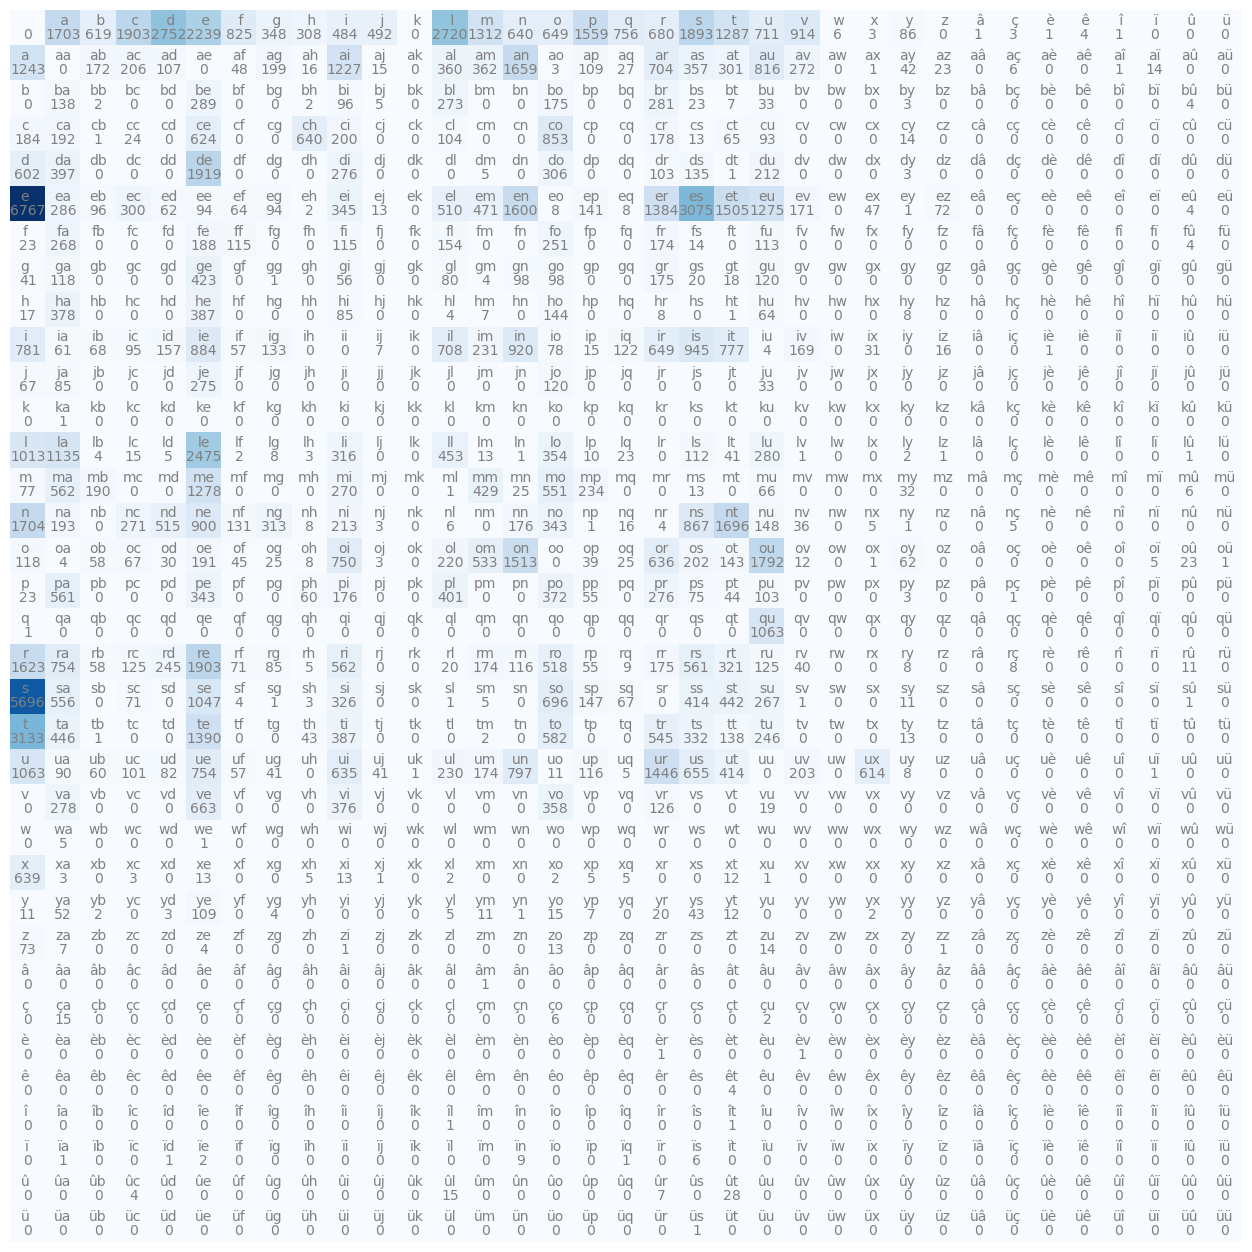

In [8]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(35):
    for j in range(35):
        chstr = index_to_string[i] + index_to_string[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, N[i,j].item(), ha='center', va='top', color='gray')
plt.axis('off')

In [9]:
P = N.float()
P = P / P.sum(1, keepdim=True)

In [92]:
g = torch.Generator()

out = []
ix = torch.multinomial(P[0], num_samples=1, replacement=True, generator=g).item()
for i in range(40):
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(index_to_string[ix])
print(''.join(out))
    


NameError: name 'P' is not defined

In [69]:
N2 = torch.zeros((35*35, 35), dtype=torch.int32)

In [70]:
for ch1, ch2, ch3 in zip(text, text[1:], text[2:]):
    N2[string_to_index[ch1]*35+string_to_index[ch2], string_to_index[ch3]] += 1

In [71]:
P2 = N2.float()
P2 = P2 / P2.sum(1, keepdim=True)

In [73]:
out = []
ix1 = torch.multinomial(P[0], num_samples=1, replacement=True, generator=g).item()
out.append(index_to_string[ix1])
ix2 = torch.multinomial(P[ix1], num_samples=1, replacement=True, generator=g).item()
out.append(index_to_string[ix2])
for i in range(40):
    p2 = P2[ix1*35+ix2]
    ix3 = torch.multinomial(p2, num_samples=1, replacement=True, generator=g).item()
    out.append(index_to_string[ix3])
    ix1 = ix2
    ix2 = ix3
print(''.join(out))

leupiels la fet de pet le obste ens tontis


In [101]:
loglikelihood1, loglikelihood2 = 0, 0
n = 0

for ch1, ch2, ch3 in zip(text, text[1:], text[2:]):
    ix1 = string_to_index[ch1]
    ix2 = string_to_index[ch2]
    ix3 = string_to_index[ch3]

    prob1 = P[ix2, ix3]
    prob2 = P2[ix1*35+ix2, ix3]

    loglikelihood1 += torch.log(prob1)
    loglikelihood2 += torch.log(prob2)
    n += 1

print(f'Negative log likelihood random ={-np.log(1/35)}')
print(f'Negative log likelihood bigram ={-loglikelihood1}')
print(f'Mean = {-loglikelihood1/n:4f}')
print(f'Negative log likelihood trigram ={-loglikelihood2}')
print(f'Mean = {-loglikelihood2/n:4f}')

Negative log likelihood random =3.5553480614894135
Negative log likelihood bigram =295852.0
Mean = 2.204988
Negative log likelihood trigram =244083.734375
Mean = 1.819158


In [7]:
words = text.split(' ')
print(len(set(words)))

5462


In [76]:
Nw = torch.zeros((5462, 5462), dtype=torch.int32)

In [8]:
words_to_index = {s:i for i,s in enumerate(set(words))}

In [9]:
index_to_words = {i:s for s,i in words_to_index.items()}

In [88]:
for w1, w2 in zip(words, words[1:]):
    Nw[words_to_index[w1], words_to_index[w2]] += 1

In [89]:
Pw = Nw.float()
Pw = Pw / Pw.sum(1, keepdim=True)

In [90]:
out = []
ix = 0
for i in range(40):
    p = Pw[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(index_to_words[ix]+' ')
print(''.join(out))

des bois car j aiguisais lentement se pavane avec la fecondite nous pour rassasier ma sombre et pourtant nous avons travaille c est enferme et cependant qu en vont vers l orchestre sonore une antique momie dessins auxquels la girouette 


In [102]:
loglikelihood = 0
n = 0

for w1, w2 in zip(words, words[1:]):
    ix1 = words_to_index[w1]
    ix2 = words_to_index[w2]

    prob = Pw[ix1, ix2]

    loglikelihood += torch.log(prob)
    n += 1

print(f'Negative log likelihood random words ={-np.log(1/len(set(words)))}')
print(f'Negative log likelihood word-gram ={-loglikelihood}')
print(f'Mean = {-loglikelihood/n}')

Negative log likelihood random words =8.60557030203365
Negative log likelihood word-gram =68256.1015625
Mean = 2.741318941116333


In [115]:
xs, ys = [], []

for ch1, ch2 in zip(text, text[1:]):
    xs.append(string_to_index[ch1])
    ys.append(string_to_index[ch2])

xs, ys = torch.tensor(xs), torch.tensor(ys)
num = xs.nelement()

In [117]:
W = torch.randn((35,35), generator=g, requires_grad=True)

In [124]:
xhot = F.one_hot(xs, num_classes=35).float()
old_loss = 100
ite = 0
while True:
    logits = xhot @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(num), ys].log().mean()

    W.grad = None
    loss.backward()

    W.data += -50 * W.grad

    if np.abs(old_loss-loss.item())<0.00001:
        print(f'Final loss after {ite} interations is {loss.item()}')
        break
    old_loss = loss.item()
    ite +=1

Final loss after 433 interations is 2.21195912361145


In [128]:
out = []
ix = 0
for i in range(40):
    xhot = F.one_hot(torch.tensor([ix]), num_classes=35).float()
    logits = xhot @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    out.append(index_to_string[ix]+' ')
print(''.join(out))

lame pourquoi avions supplicies tache araignees rentrer mouilles lamentables clair craigne mouilles lamentables mouilles soeurs rentrer lamentables prisons mais alimentons lisons rentrer debris rentrer durant craigne lamentables gratte rentrer reveusement alimentons rentrer lamentables mouches rentrer clair broie gratte alimentons lisons 


In [163]:
x2s, y2s = [], []

for ch1, ch2, ch3 in zip(text, text[1:], text[2:]):
    x2s.append(string_to_index[ch1]+string_to_index[ch2])
    y2s.append(string_to_index[ch3])

x2s, y2s = torch.tensor(x2s), torch.tensor(y2s)
num = x2s.nelement()

W2 = torch.randn((35*35,35), generator=g, requires_grad=True)

In [167]:
x2hot = F.one_hot(x2s, num_classes=35*35).float()

for i in range(100):
    logits = x2hot @ W2
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(num), y2s].log().mean()

    W2.grad = None
    loss.backward()

    W2.data += -100 * W2.grad

print(f'Final loss is {loss.item()}')

Final loss is 2.44804048538208


In [ ]:
out = []
ix = 0
for i in range(40):
    x2hot = F.one_hot(torch.tensor([ix]), num_classes=35*35).float()
    logits = x2hot @ W2
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    out.append(index_to_string[ix]+' ')
print(''.join(out))

In [12]:
n1, n2 = int(0.8*len(words)), int(0.9*len(words))
n1

19920

In [516]:
def build_text_dataset(text, block_size=5):
    X, Y = [], []


    context = [0]*block_size
    for ch in text:
        ix = string_to_index[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

    return torch.tensor(X), torch.tensor(Y)

Xtr, Ytr = build_text_dataset(text[:n1])
Xval, Yval = build_text_dataset(text[n1:n2])
Xte, Yte = build_text_dataset(text[n2:])

In [644]:
#Embedings
C = torch.randn((35, 10))
#1st layer
W1 = torch.randn((50,200)) * (5/3)/((50)**0.5)
b1 = torch.randn(200) * 0.1
#2nd layer
W2 = torch.randn((200, 35)) * 0.1
b2 = torch.randn(35) * 0.1
#Batch norm
bngain = torch.rand((1, 200)) * 0.1 + 1
bnbias = torch.rand((1, 200)) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
sum(p.nelement() for p in parameters)
for p in parameters:
  p.requires_grad = True

In [104]:
#utility function to compare manual gradients and pytorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact : {str(ex):5s} | approximate : {str(app):5s} | max diff : {maxdiff}') 

In [652]:
# Batch
ix = torch.randint(0, Xtr.shape[0], (32,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

# Embeddings
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)

# Linear Layer 1
hprebn = embcat @ W1 +b1

# BatchNorm
bnmeani = 1/32*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(32-1)*bndiff2.sum(0, keepdim=True) #(n-1) is called Bessel's correction
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# Non-Linerarity
h = torch.tanh(hpreact)

# Linear Layer 2
logits = h @ W2 + b2

# Cross-entropy
logits_max = logits.max(1, keepdim=True).values
norm_logits = logits - logits_max #for numerical stability
counts = norm_logits.exp()
count_sum = counts.sum(1, keepdim=True)
count_sum_inv = count_sum**-1
probs = counts * count_sum_inv
logprobs = probs.log()
loss = -logprobs[range(32), Yb].mean()

for p in parameters:
    p.grad = None

for t in [logprobs, probs, count_sum_inv, count_sum, counts, norm_logits, logits_max, logits, 
            h, hpreact, bnraw, bnvar_inv, bnvar, bndiff2, bndiff, bnmeani, hprebn, embcat, emb]:
    t.retain_grad()

loss.backward()
print(loss)


tensor(4.0203, grad_fn=<NegBackward0>)


In [653]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(32), Ytr[ix]] = -1/32
cmp('logprobs', dlogprobs, logprobs)

dprobs = dlogprobs / probs
cmp('probs', dprobs, probs)

dcount_sum_inv = (counts * dprobs).sum(1, keepdim=True)
cmp('dcount_sum_inv', dcount_sum_inv, count_sum_inv)

dcount_sum = - dcount_sum_inv * count_sum**-2
cmp('dcount_sum', dcount_sum, count_sum)

dcounts = torch.ones_like(counts) * dcount_sum + count_sum_inv * dprobs
cmp('dcounts', dcounts, counts)

dnorm_logits = dcounts * counts
cmp('dnorm_logits', dnorm_logits, norm_logits)

dlogits_max = -dnorm_logits.sum(1, keepdim=True)
cmp('dlogits_max', dlogits_max, logits_max)

dlogits = torch.zeros_like(logits)
dlogits[range(32), logits.max(1).indices] = 1  
dlogits *= dlogits_max                               #F.one_hot(logits.max(1).indices, num_class=logits.shape[1]) * dlogits_max
dlogits += torch.ones_like(logits) * dnorm_logits 
cmp('dlogits', dlogits, logits)

dh = dlogits @ W2.T
cmp('dh', dh, h)

dW2 = h.T @ dlogits
cmp('dW2', dW2, W2)

db2 = dlogits.sum(0)
cmp('db2', db2, b2)

dhpreact = (1 - torch.tanh(hpreact)**2) * dh
cmp('dhpreac', dhpreact, hpreact)

dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
cmp('dbngain', dbngain, bngain)

dbnraw = bngain * dhpreact
cmp('dbnraw', dbnraw, bnraw)

dbnbias = dhpreact.sum(0, keepdim=True)
cmp('dbnbias', dbnbias, bnbias)

dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
cmp('dbnvar_inv', dbnvar_inv, bnvar_inv)

dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
cmp('dbnvar', dbnvar, bnvar)

dbndiff2 = 1/(32-1)*torch.ones_like(bndiff2) * dbnvar
cmp('dbndiff2', dbndiff2, bndiff2)

dbndiff = bnvar_inv * dbnraw + 2 * bndiff * dbndiff2
cmp('dbndiff', dbndiff, bndiff)

dbnmeani = - dbndiff.sum(0, keepdim=True)
cmp('dbnmeani', dbnmeani, bnmeani)

dhprebn = dbndiff + (torch.ones_like(hprebn)/32) * dbnmeani
cmp('dhprebn', dhprebn, hprebn)

dembcat = dhprebn @ W1.T
cmp('dembcat', dembcat, embcat)

dW1 = embcat.T @ dhprebn
cmp('dW1', dW1, W1)

db1 = dhprebn.sum(0)
cmp('db1', db1, b1)

demb = dembcat.view(emb.shape)
cmp('demb', demb, emb)

dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
cmp('dC', dC, C)

logprobs        | exact : True  | approximate : True  | max diff : 0.0
probs           | exact : True  | approximate : True  | max diff : 0.0
dcount_sum_inv  | exact : True  | approximate : True  | max diff : 0.0
dcount_sum      | exact : True  | approximate : True  | max diff : 0.0
dcounts         | exact : True  | approximate : True  | max diff : 0.0
dnorm_logits    | exact : True  | approximate : True  | max diff : 0.0
dlogits_max     | exact : True  | approximate : True  | max diff : 0.0
dlogits         | exact : True  | approximate : True  | max diff : 0.0
dh              | exact : True  | approximate : True  | max diff : 0.0
dW2             | exact : True  | approximate : True  | max diff : 0.0
db2             | exact : True  | approximate : True  | max diff : 0.0
dhpreac         | exact : True  | approximate : True  | max diff : 0.0
dbngain         | exact : True  | approximate : True  | max diff : 0.0
dbnraw          | exact : True  | approximate : True  | max diff : 0.0
dbnbia

In [664]:
# Faster way to get dlogits from logits and Yb

dlogits = F.softmax(logits, 1)
dlogits[range(32), Yb] -= 1
dlogits /= 32
cmp('dlogits', dlogits, logits)

# Faster way to get dhprebn from dhpreact 
dhprebn = bngain * bnvar_inv / 32 * (dhpreact * 32 - dhpreact.sum(0) - 32/31 * bnraw * (dhpreact * bnraw).sum(0))
cmp('dhpreact', dhpreact, hpreact)

dlogits         | exact : False | approximate : True  | max diff : 5.587935447692871e-09
dhpreact        | exact : True  | approximate : True  | max diff : 0.0


In [668]:
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    
    # manual backprop! 
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    dhpreact = (1.0 - h**2) * dh
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain * bnvar_inv / 32 * (dhpreact * n - dhpreact.sum(0) - n/(n-1) * bnraw * (dhpreact * bnraw).sum(0))
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    demb = (dhprebn @ W1.T).view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
        for j in range(Xb.shape[1]):
            ix = Xb[k,j]
            dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      p.data += -lr * grad 

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 2.7583
  10000/ 200000: 1.6271
  20000/ 200000: 1.7022
  30000/ 200000: 1.5443
  40000/ 200000: 1.6058
  50000/ 200000: 1.6294
  60000/ 200000: 1.6525
  70000/ 200000: 1.6793
  80000/ 200000: 1.6374
  90000/ 200000: 1.6758
 100000/ 200000: 1.6755
 110000/ 200000: 1.6092
 120000/ 200000: 1.4818
 130000/ 200000: 1.3916
 140000/ 200000: 1.8683
 150000/ 200000: 1.5846
 160000/ 200000: 1.6376
 170000/ 200000: 1.4612
 180000/ 200000: 1.8049
 190000/ 200000: 1.4875


In [670]:
emb = C[Xval]
h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 +b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
print(f'Loss on validation set is {loss.item():4f}')

Loss on validation set is 2.991290


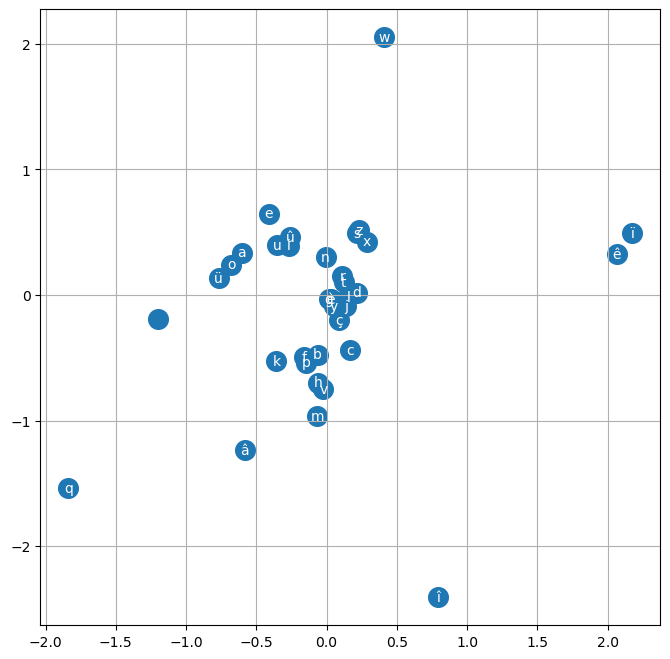

In [314]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), index_to_string[i], ha='center', va='center', color='white')
plt.grid('minor')

In [674]:
out = []
context = [0]*5

for _ in range(40):
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2        
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()        
    context = context[1:] + [ix]
    out.append(ix)

print(''.join(index_to_string[i] for i in out))

voixrntus billqunt dannûtllez vunxzèezas


In [42]:
def build_words_dataset(words):
    block_size = 5
    X, Y = [], []


    context = [0]*block_size
    for w in words:
        ix = words_to_index[w]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

    return torch.tensor(X), torch.tensor(Y)

nw1, nw2 = int(0.8*len(words)), int(0.9*len(words))
Xwtr, Ywtr = build_words_dataset(words[:nw1])
Xwval, Ywval = build_words_dataset(words[nw1:nw2])
Xwte, Ywte = build_words_dataset(words[nw2:])

In [110]:
intwords = int(len(set(words)))

Cw = torch.randn((intwords, 50))
Ww1 = torch.randn((250,100)) * (5/3)/250**0.5
bw1 = torch.randn(100) * 0.01
Ww2 = torch.randn((100, intwords)) * 0.01
bw2 = torch.randn(intwords) * 0

bngain = torch.ones((1, 100))
bnbias = torch.zeros((1, 100))

parameters = [Cw, Ww1, bw1, Ww2, bw2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [111]:
old_loss = 100
ite = 0

while True :
    ix = torch.randint(0, Xwtr.shape[0]-32, (1,)) + torch.arange(32)
    emb = Cw[Xwtr[ix]]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ Ww1 +bw1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ Ww2 + bw2
    loss = F.cross_entropy(logits, Ywtr[ix])

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if ite < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    if np.abs(old_loss-loss.item())<0.00001:
        print(f'Final loss after {ite} interations is {loss.item()}')
        break
    
    if ite > 200000:
        break
    old_loss = loss.item()
    ite +=1

Final loss after 93884 interations is 0.0981479287147522


In [125]:
with torch.no_grad():
    emb = Cw[Xwtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ Ww1 +bw1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [126]:
emb = Cw[Xwval]
embcat = emb.view(emb.shape[0], -1)
hpreact = embcat @ Ww1 +bw1
hpreact = bngain * (hpreact - bnbias) / bnstd + bnbias
h = torch.tanh(hpreact)
logits = h @ Ww2 + bw2
loss = F.cross_entropy(logits, Ywval)
print(f'Loss on validation set is {loss.item():4f}')

Loss on validation set is 11.834370


In [163]:
out = []
context = [0]*5

for _ in range(40):
    emb = Cw[torch.tensor([context])]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ Ww1 +bw1
    hpreact = bngain * (hpreact - bnbias) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ Ww2 + bw2      
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()        
    context = context[1:] + [ix]
    out.append(ix)

print(''.join(index_to_words[i]+' ' for i in out))

que leurs anges noir tenebreux prend la terre se carcasse etre que mon nez se fait que est ame tenebres ou mettrons humide se douleurs mes soir importe cette celebres dont andromaque bizarre vampire ses bras un sont soleil femme 


In [13]:
from torch.nn.functional import linear


class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_out**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.trainning = True
        # Parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Running buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.trainning:
            xmean = x.mean(0, keepdims=True)
            xvar = x.var(0, keepdims=True)
        else : 
            xmean = self.running_mean
            xvar = self.running_var
        
        self.out = self.gamma * ((x - xmean) / torch.sqrt(xvar + self.eps)) + self.beta

        if self.trainning:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

n_emb =10
n_hidden = 100
g = torch.Generator()
n_charac = 35
block_size = 5

C = torch.randn((n_charac, n_emb), generator=g)
layers = [
    Linear(block_size*n_emb, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_charac, bias=False), BatchNorm1d(n_charac)
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1           #last layer less confident
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3        #gain for tanh
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True


39720


In [482]:
old_loss = 100
batch_size = 32
lossi, ud = [], []
ite = 0

while True :
    # Batch
    ix = torch.randint(0, Xtr.shape[0]-batch_size, (1,)) + torch.arange(batch_size)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # Backward
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if ite <10000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
    
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if np.abs(old_loss-loss.item())<0.00001:
        print(f'Final loss after {ite} interations is {loss.item()}')
        break
    
    if ite > 20000:
        break

    old_loss = loss.item()
    ite +=1


Final loss after 9532 interations is 1.6267997026443481


In [483]:
emb = C[Xval]
x = emb.view(emb.shape[0], -1)
for layer in layers:
    x = layer(x)
loss = F.cross_entropy(x, Yval)
print(f'Loss on validation set is {loss.item():4f}')

Loss on validation set is 1.820639


layer 2 (Tanh) mean : -0.007915, sdt : 0.784245, saturated : 25.739357%
layer 5 (Tanh) mean : -0.003039, sdt : 0.798875, saturated : 28.936180%
layer 8 (Tanh) mean : -0.006766, sdt : 0.806114, saturated : 29.703647%
layer 11 (Tanh) mean : 0.010774, sdt : 0.797856, saturated : 26.974353%


Text(0.5, 1.0, 'Activation distribution')

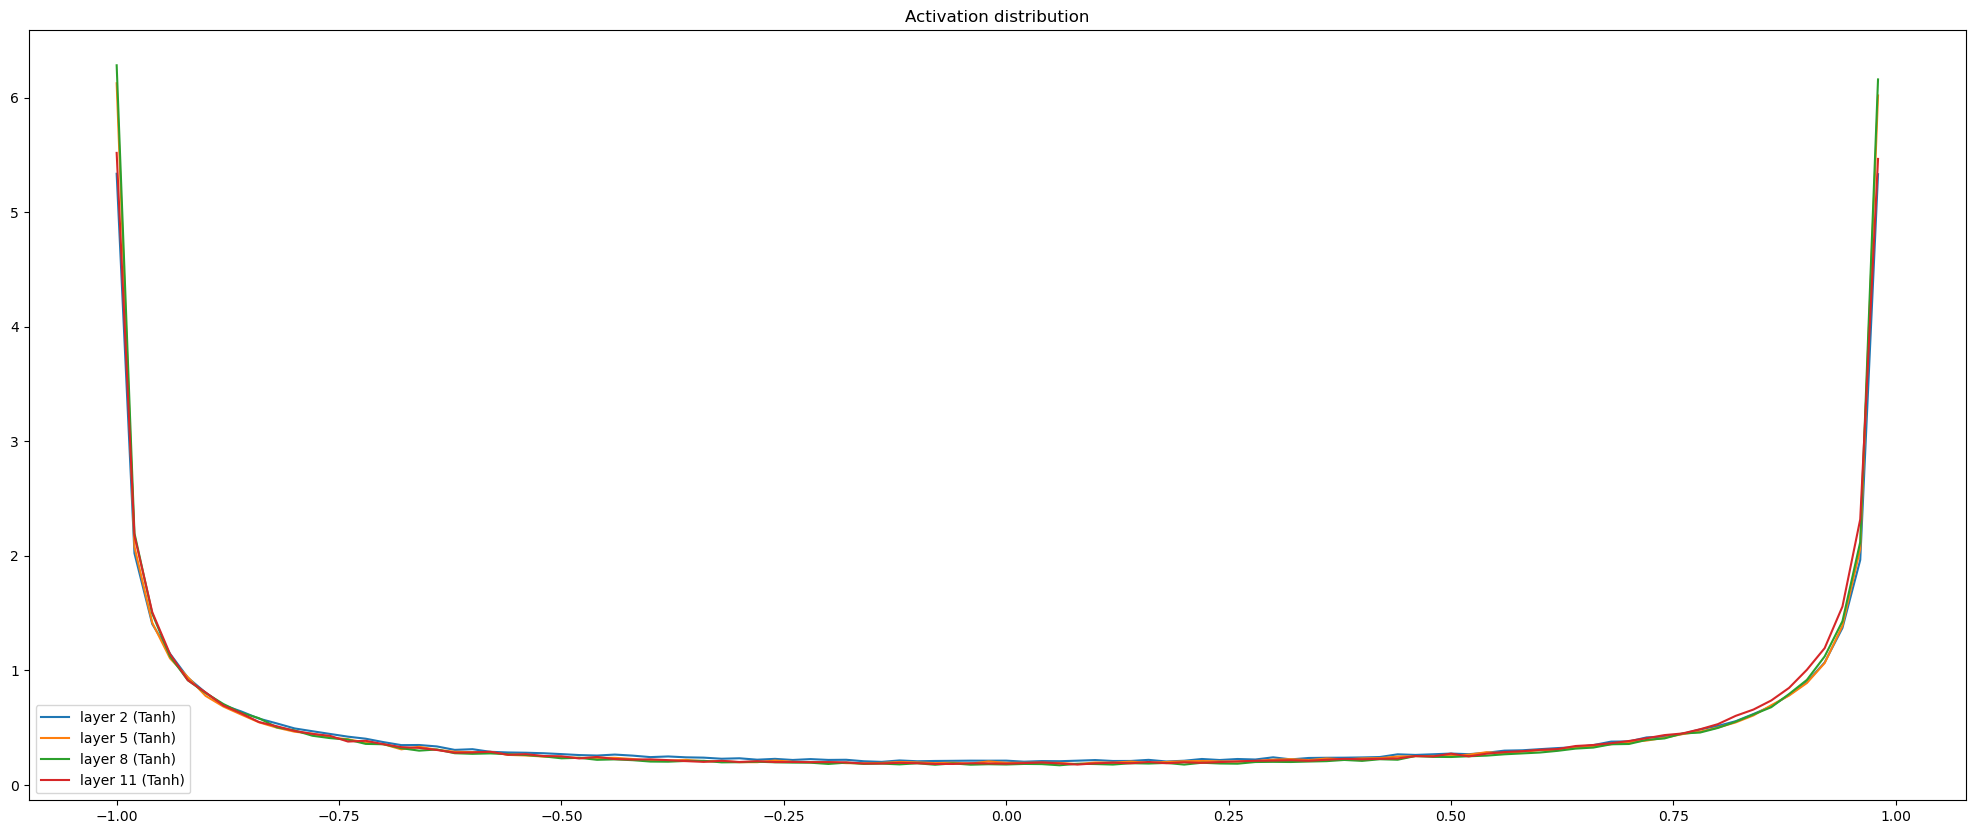

In [473]:
plt.figure(figsize=(25, 10))
legend = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} ({layer.__class__.__name__}) mean : {t.mean():2f}, sdt : {t.std():2f}, saturated : {(t.abs()>0.97).float().mean():%}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legend.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legend)
plt.title('Activation distribution')

In [474]:
plt.figure(figsize=(25, 10))
legend = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__}) mean : {t.mean():+2f}, sdt : {t.std():2f}, saturated : {(t.abs()>0.97).float().mean():%}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legend.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legend)
plt.title('Gradient distribution')

AttributeError: 'NoneType' object has no attribute 'mean'

<Figure size 2500x1000 with 0 Axes>

Weight (35, 10) mean : -0.000409, sdt : 1.638035e-02, grad/data ratio : 1.555460e-02
Weight (50, 100) mean : +0.000230, sdt : 1.577422e-02, grad/data ratio : 5.745525e-02
Weight (100, 100) mean : -0.000071, sdt : 1.040327e-02, grad/data ratio : 4.713233e-02
Weight (100, 100) mean : -0.000082, sdt : 9.802876e-03, grad/data ratio : 4.494279e-02
Weight (100, 100) mean : -0.000074, sdt : 9.418099e-03, grad/data ratio : 4.408999e-02
Weight (100, 35) mean : +0.000125, sdt : 1.295215e-02, grad/data ratio : 4.253960e-02


Text(0.5, 1.0, 'Weights gradient distribution')

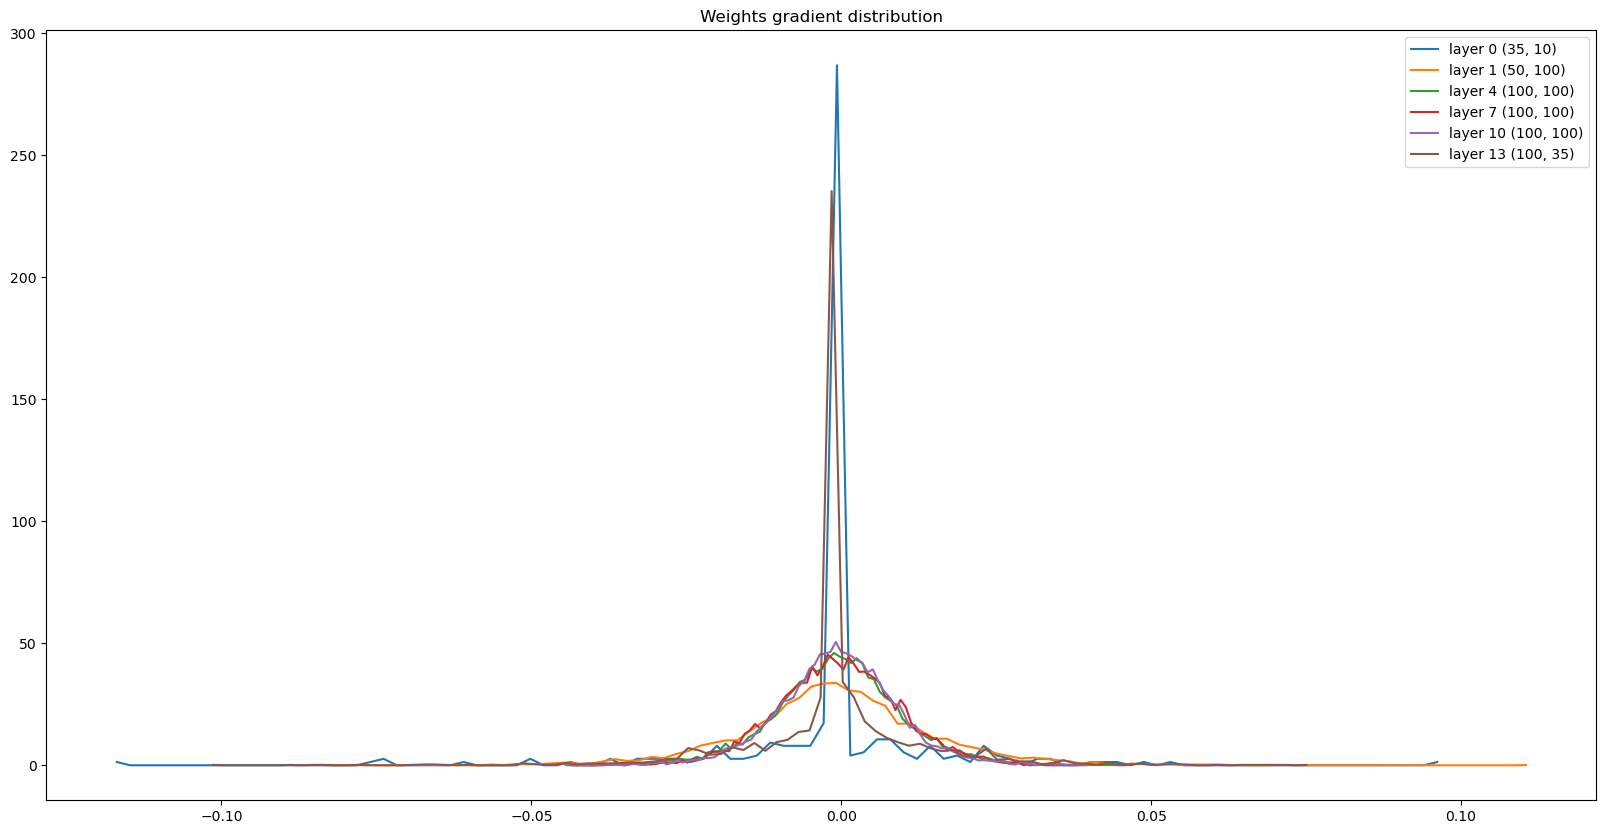

In [475]:
plt.figure(figsize=(20, 10))
legend = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(f'Weight {tuple(p.shape)} mean : {t.mean():+2f}, sdt : {t.std():e}, grad/data ratio : {t.std()/p.std():e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legend.append(f'layer {i} {tuple(p.shape)}')
plt.legend(legend)
plt.title('Weights gradient distribution')

Text(0.5, 1.0, 'Weights gradient distribution')

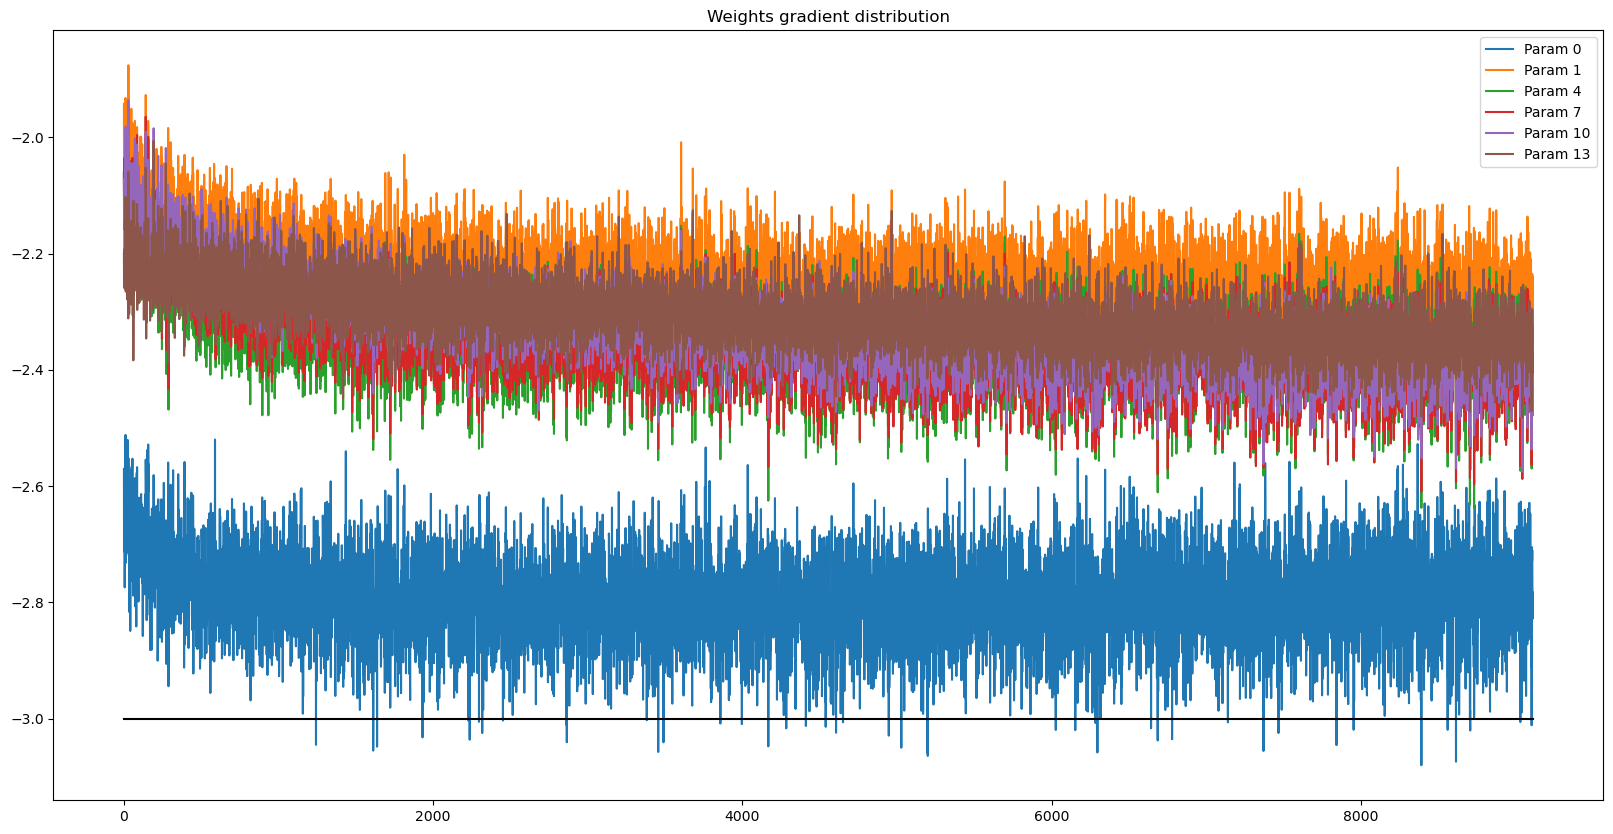

In [476]:
plt.figure(figsize=(20, 10))
legend = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legend.append(f'Param {i}')
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legend)
plt.title('Weights gradient distribution')

In [480]:
with torch.no_grad():
    for i, layer in enumerate(layers):
        if isinstance(layer, BatchNorm1d):
            layer.trainning = False

prompt = 'enfer'
context = [string_to_index[i] for i in prompt]
out = []

for i in range(40):
    emb = C[torch.tensor([context])]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    ix = torch.multinomial(torch.clamp(x, min=0), num_samples=1, generator=g).item()   
    out.append(ix)
    context = context[1:] + [ix]

print(''.join(index_to_string[i] for i in out))

 un futs lang vieim vieune de ml couvsie


In [419]:
x

tensor([[ 0.2044, -0.0992, -0.0083,  0.0679,  0.1260,  0.0973, -0.1394,  0.0904,
          0.0271, -0.0171,  0.0829,  0.0928,  0.1067, -0.0376, -0.0265,  0.0591,
         -0.0063, -0.1492,  0.0267,  0.0220,  0.0626, -0.0294,  0.1883,  0.0550,
         -0.1245,  0.1532, -0.1351,  0.1108, -0.0454, -0.0203,  0.0026, -0.1216,
         -0.1003,  0.0486,  0.0844]], grad_fn=<AddBackward0>)

# RNN  
Along the lines of [Sutskever et al. 2011](https://icml.cc/2011/papers/524_icmlpaper.pdf)

In [7]:
def build_window_dataset(text, window_size):
    X, Y = [], []
    context = [string_to_index[ch] for ch in text[:window_size]]
    
    for ch in text[window_size:]:
        ix = string_to_index[ch]
        X.append(context)
        context = context[1:] + [ix]
        Y.append(ix)

    return torch.tensor(X), torch.tensor(Y)

In [8]:
input_window, target_window = build_window_dataset(text, 50)

In [9]:
indices = torch.randperm(input_window.size()[0])
input_window = input_window[indices]
target_window = target_window [indices]

In [10]:
n1, n2 = int(0.8*input_window.size()[0]), int(0.9*input_window.size()[0])

Xtr, Ytr = input_window[:n1], target_window[:n1]
Xval, Yval = input_window[n1:n2], target_window[n1:n2]
Xte, Yte = input_window[n2:], target_window[n2:]

In [92]:
n_emb =10
n_hidden = 20
g = torch.Generator()
n_charac = 35

C = torch.randn((n_charac, n_emb), generator=g)
Wxh = torch.randn((n_emb, n_hidden), generator=g) * 5/3 / (n_hidden**0.5)
Whh = torch.randn((n_hidden, n_hidden), generator=g) * 5/3 / (n_hidden**0.5)
Who = torch.randn((n_hidden, n_charac), generator=g) * 5/3 / (n_charac**0.5)
biash = torch.zeros(n_hidden)
biaso = torch.zeros(n_charac)
parameters = [C, Wxh, Whh, Who, biash, biaso]
for p in parameters:
    p.requires_grad = True

In [125]:
out[0]

tensor([ 0.5603, -0.3879,  0.7830,  1.1922,  0.9234, -1.2422,  0.6053,  1.3000,
        -0.6725,  1.1173,  0.7501,  0.6975, -0.6841,  0.0079,  1.0114,  1.1299,
         0.9859,  0.8835,  1.3999, -0.4565,  1.6328,  0.4695, -0.0730,  0.3690,
         1.1754, -0.1205,  1.4509,  0.3485,  0.6501, -0.2139,  0.3867,  0.6751,
        -2.1268,  0.4076, -0.4941], grad_fn=<SelectBackward0>)

In [128]:
Yb

tensor([15])

In [124]:
Yb[i]

tensor(12)

In [126]:
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

#with torch.no_grad():

# kick off optimization
for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (1,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  hidden = torch.randn((1, n_hidden), generator=g) / n_hidden**0.5
  out_seq = []
  loss = 0

  # forward pass
  embeddings = C[Xb][0] # embed the characters into vectors
  
  for i in range(len(embeddings)) :
    
    # input layer
    xpreac = embeddings[i] @ Wxh
    # hidden layer
    hpreac = hidden @ Whh 
    # non linearity
    hidden = torch.tanh(xpreac + hpreac + biash)
    # output
    out = hidden @ Who + biaso
    out_seq.append(out)
    loss += F.cross_entropy(out[0], Yb[i]) # loss function
  
  out_seq = torch.stack((out_seq))
  # backward pass
  for p in parameters:
    p.grad = None
  
  for t in [out_seq, out, hidden, hpreac, xpreac, embeddings]:
    print(t.shape)
    t.retain_grad()
  
  loss.backward()
  
  # manual backprop! 
  # -----------------
  dout = F.softmax(out_seq, 1)
  dout[range(n), 0, Yb] -= 1
  dout /= n
  dhidden = dout @ Who.T
  dWho = hidden.T @ dout
  dbo = dout.sum(0)
  dhpreact = (1.0 - hidden**2) * dhidden
  print(dhpreact.shape)
  print(embeddings.shape)
  print(Wxh.shape)
  dWhh = hidden.T @ dhpreact
  dbh = dhpreact.sum(0).squeeze()
  demb = (dhprebn @ W1.T).view(emb.shape)
  break
  dC = torch.zeros_like(C)
  for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
          ix = Xb[k,j]
          dC[ix] += demb[k,j]
  grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
  # -----------------

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p, grad in zip(parameters, grads):
    #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
    p.data += -lr * grad # new way of swole doge TODO: enable

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [111]:
dout[-1]

tensor([[0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
         0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
         0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
         0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312]],
       grad_fn=<SelectBackward0>)

In [118]:
Whh.grad

In [110]:
cmp('dout', dout[-1], out)

TypeError: all(): argument 'input' (position 1) must be Tensor, not bool

In [30]:
class RNN:
    def __init__(self, fan_in, fan_hidden, fan_out):
        self.whx = Linear(fan_in, fan_hidden, False)
        self.whh = Linear(fan_hidden, fan_hidden, False)
        self.woh = Linear(fan_hidden, fan_out, True)
        self.bias = torch.zeros(fan_hidden)
        self.whx.weight *= 5/3
        self.whh.weight *= 5/3
        self.woh.weight *= 5/3
    
    def __call__(self, x, last_hidden):
        self.hidden = Tanh()(self.whx(x) + self.whh(last_hidden) + self.bias)
        self.out = self.woh(self.hidden)
        return self.hidden, self.out
    
    def parameters(self):
        layers = [self.whx, self.whh, self.woh]
        return [p for layer in layers for p in layer.parameters()] + [self.bias]
    
    def init_hidden(self, fan_hidden):
        return torch.randn((1, fan_hidden), generator=g) / fan_hidden**0.5

In [31]:
n_emb =10
n_hidden = 20
g = torch.Generator()
n_charac = 35

C = torch.randn((n_charac, n_emb), generator=g)
rnn = RNN(n_emb, n_hidden, n_charac)

parameters = [C] + [p for p in rnn.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

1705


In [32]:
textin = Xtr[0]
hidden = rnn.init_hidden(n_hidden)


for ch in textin:
    hidden, out = rnn(C[ch], hidden)

print(out)

tensor([[-0.4863,  1.3344, -0.3983,  0.9782,  1.8361, -0.4271,  0.6537,  0.1316,
         -0.7458,  0.4424, -0.3967, -0.0782, -1.6358,  0.0311,  0.7696, -1.9448,
          0.1525, -0.9064, -0.0308,  0.7000,  1.5673,  0.7164, -0.6771, -0.4690,
         -1.0447, -0.6708, -1.3388,  0.2200, -0.9800, -0.4051, -0.3129, -0.6712,
          1.5918,  1.8754, -0.9870]], grad_fn=<AddBackward0>)
